In [10]:
library(magrittr)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [11]:
tran_df = readr::read_tsv('data/matrix/wikidata-v0.1/transformed-features.tsv.bz2') %>%
  dplyr::select(-dplyr::matches('[CD]duft[CD]', ignore.case=F))

Parsed with column specification:
cols(
  .default = col_character(),
  status = col_integer(),
  prior_logit = col_double(),
  degree_CduftD = col_double(),
  degree_CpiwP = col_double(),
  degree_CsdiC = col_double(),
  `degree_C<hpC` = col_double(),
  `degree_C<ioC` = col_integer(),
  `degree_Chp>C` = col_double(),
  `degree_Cio>C` = col_double(),
  degree_DduftC = col_double(),
  degree_DgaG = col_double(),
  `degree_D<soD` = col_double(),
  `degree_Dso>D` = col_double(),
  `dwpc_C<hpCduftD` = col_integer(),
  `pdwpc_C<hpCduftD` = col_integer(),
  `rdwpc_C<hpCduftD` = col_integer(),
  `dwpc_C<hpCduftDduftCduftD` = col_integer(),
  `pdwpc_C<hpCduftDduftCduftD` = col_integer(),
  `rdwpc_C<hpCduftDduftCduftD` = col_integer(),
  `dwpc_C<hpChp>CduftD<soD` = col_double()
  # ... with 203 more columns
)
See spec(...) for full column specifications.
Warning message:
“374 parsing failures.
 row                        col               expected actual
1130 pdwpc_CduftDduftChp>CduftD no trail

In [12]:
dim(tran_df)

[1] 14845    39

In [13]:
tran_df %>% tail(2)

compound_id disease_id status disease_name                     compound_name
1 Q3935297    Q6742925   0      male reproductive system disease rifapentine  
2 Q421052     Q6742925   0      male reproductive system disease everolimus   
  prior_logit degree_CpiwP degree_CsdiC degree_C<hpC degree_C<ioC ⋯
1 -8.0186     0.00000      2.9982       0            0            ⋯
2 -6.9086     0.88137      0.0000       0            0            ⋯
  rdwpc_CpiwPeGgaD dwpc_CpiwPeGgaD<soD pdwpc_CpiwPeGgaD<soD
1 0                0                   0                   
2 0                0                   0                   
  rdwpc_CpiwPeGgaD<soD dwpc_CpiwPeGgaDso>D pdwpc_CpiwPeGgaDso>D
1 0                    0                   0                   
2 0                    0                   0                   
  rdwpc_CpiwPeGgaDso>D dwpc_CsdiCpiwPeGgaD pdwpc_CsdiCpiwPeGgaD
1 0                    0                   0                   
2 0                    0                   0                   
  rdwpc_CsdiCpiwPeGgaD
1 0                   
2 0

In [5]:
# auroc_df = readr::read_tsv('data/feature-performance/auroc.tsv') %>%
#   dplyr::filter(! grepl('[CD][pt][CD]', feature))

In [14]:
X_dwpc = tran_df %>%
  dplyr::select(prior_logit, starts_with('degree'), starts_with('dwpc')) %>%
  as.matrix

X_pdwpc = tran_df %>%
  dplyr::select(prior_logit, starts_with('degree'), starts_with('pdwpc')) %>%
  as.matrix

X_rdwpc = tran_df %>%
  dplyr::select(prior_logit, starts_with('degree'), starts_with('rdwpc')) %>%
  as.matrix

X_split = tran_df %>%
  dplyr::select(prior_logit, starts_with('degree'), starts_with('pdwpc'), starts_with('rdwpc')) %>%
  as.matrix

X_all = tran_df %>%
  dplyr::select(prior_logit, starts_with('degree'), contains('dwpc')) %>%
  as.matrix

dim(X_rdwpc)
dim(X_split)
dim(X_all)

[1] 14845    18

[1] 14845    26

[1] 14845    34

In [ ]:
penalty = ifelse(colnames(X_dwpc) == 'prior_logit', 0, 1)
fit_dwpc = hetior::glmnet_train(X_dwpc, tran_df$status, alpha = 0, penalty.factor=penalty, cores=10)
fit_pdwpc = hetior::glmnet_train(X_pdwpc, tran_df$status, alpha = 0, penalty.factor=penalty, cores=10)
fit_rdwpc = hetior::glmnet_train(X_rdwpc, tran_df$status, alpha = 0, penalty.factor=penalty, cores=10)

In [8]:
penalty = ifelse(colnames(X_split) == 'prior_logit', 0, 1)
fit_split = hetior::glmnet_train(X_split, tran_df$status, alpha = 0, penalty.factor=penalty, cores = 10)

In [9]:
penalty = ifelse(colnames(X_all) == 'prior_logit', 0, 1)
fit_all = hetior::glmnet_train(X_all, tran_df$status, alpha = 0, penalty.factor=penalty, cores = 10)

In [10]:
fit_dwpc$vtm[c('auroc', 'auprc', 'tjur')]
fit_pdwpc$vtm[c('auroc', 'auprc', 'tjur')]
fit_rdwpc$vtm[c('auroc', 'auprc', 'tjur')]

$auroc
[1] 0.9114026

$auprc
[1] 0.7527511

$tjur
[1] 0.4124837

$auroc
[1] 0.8481643

$auprc
[1] 0.6083106

$tjur
[1] 0.2988322

$auroc
[1] 0.9067979

$auprc
[1] 0.7431891

$tjur
[1] 0.3941461

In [11]:
fit_split$vtm[c('auroc', 'auprc', 'tjur')]
fit_all$vtm[c('auroc', 'auprc', 'tjur')]

$auroc
[1] 0.90884

$auprc
[1] 0.7459096

$tjur
[1] 0.3959022

$auroc
[1] 0.9111302

$auprc
[1] 0.75215

$tjur
[1] 0.4034352

In [12]:
uniform_prior = boot::logit(mean(tran_df$status))
X_dwpc[, 'prior_logit'] = uniform_prior
X_pdwpc[, 'prior_logit'] = uniform_prior
X_rdwpc[, 'prior_logit'] = uniform_prior
X_split[, 'prior_logit'] = uniform_prior
X_all[, 'prior_logit'] = uniform_prior

In [13]:
pred_df = tran_df %>%
  dplyr::mutate(prior = boot::inv.logit(prior_logit)) %>%
  dplyr::select(disease_name, compound_name, status, prior) %>%
  dplyr::mutate(dwpc = hetior::glmnet_predict(fit_dwpc$cv_model, X = X_dwpc)) %>%
  dplyr::mutate(pdwpc = hetior::glmnet_predict(fit_pdwpc$cv_model, X = X_pdwpc)) %>%
  dplyr::mutate(rdwpc = hetior::glmnet_predict(fit_rdwpc$cv_model, X = X_rdwpc)) %>%
  dplyr::mutate(split = hetior::glmnet_predict(fit_split$cv_model, X = X_split)) %>%
  dplyr::mutate(all = hetior::glmnet_predict(fit_all$cv_model, X = X_all))

# pred_df = tran_df %>%
#   dplyr::mutate(prior = boot::inv.logit(prior_logit)) %>%
#   dplyr::select(disease_name, compound_name, status, prior) %>%
#   dplyr::mutate(dwpc = fit_dwpc$y_pred) %>%
#   dplyr::mutate(pdwpc = fit_pdwpc$y_pred) %>%
#   dplyr::mutate(rdwpc = fit_rdwpc$y_pred) %>%
#   dplyr::mutate(split = fit_split$y_pred) %>%
#   dplyr::mutate(all = fit_all$y_pred)

In [14]:
pred_df %>% head(2)

Source: local data frame [2 x 9]

             disease_name compound_name status      prior      dwpc     pdwpc
                    (chr)         (chr)  (int)      (dbl)     (dbl)     (dbl)
1 lymphatic system cancer  Cyclosporine      0 0.04741684 0.7312773 0.7337899
2 lymphatic system cancer     Reserpine      0 0.01106874 0.6931544 0.7337899
Variables not shown: rdwpc (dbl), split (dbl), all (dbl)

In [15]:
# Pairwise correlations
pred_df %>%
  dplyr::select(prior:all) %>%
  cor() %>%
  round(3) * 100

Warning message:
In cor(.): the standard deviation is zero

prior  dwpc pdwpc rdwpc split   all
prior 100.0  14.9    NA  14.3   9.8  11.0
dwpc   14.9 100.0    NA  88.2  86.8  90.9
pdwpc    NA    NA   100    NA    NA    NA
rdwpc  14.3  88.2    NA 100.0  96.5  96.5
split   9.8  86.8    NA  96.5 100.0  99.4
all    11.0  90.9    NA  96.5  99.4 100.0

Joining by: c("disease_name", "compound_name", "status")


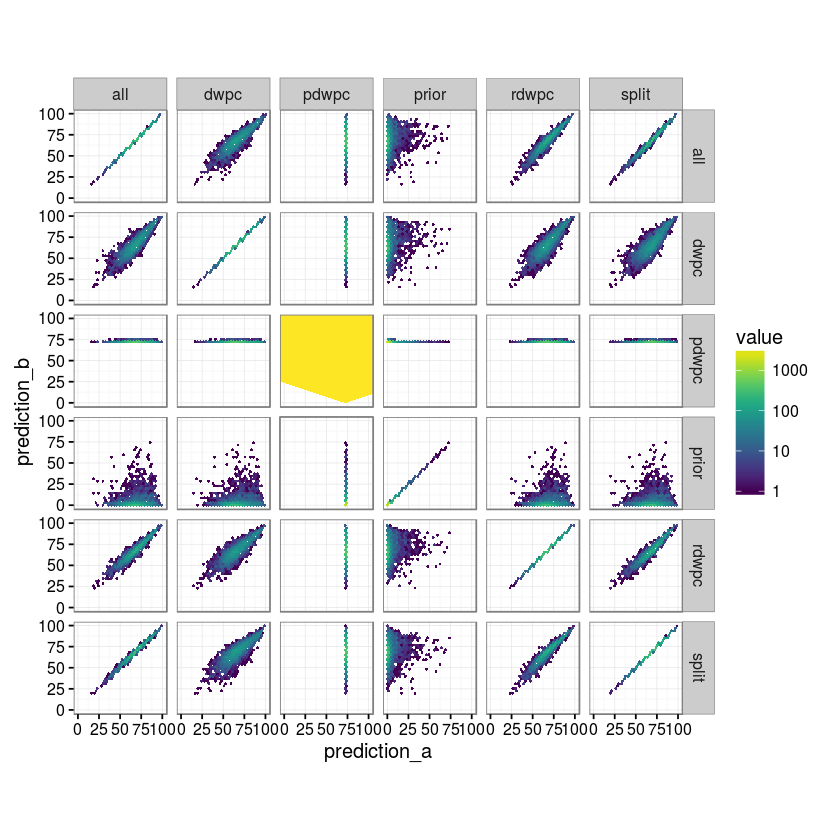

In [16]:
pred_long_df = pred_df %>% 
  tidyr::gather(predictor_set, prediction, prior:all) %>%
  dplyr::mutate(prediction = prediction * 100)

pair_df = dplyr::inner_join(
  pred_long_df %>%
    dplyr::rename(predictor_set_a = predictor_set, prediction_a = prediction),
  pred_long_df %>%
    dplyr::rename(predictor_set_b = predictor_set, prediction_b = prediction)
)

pair_df %>% 
  ggplot2::ggplot(ggplot2::aes(prediction_a, prediction_b)) +
  ggplot2::facet_grid(predictor_set_b ~ predictor_set_a) +
  ggplot2::geom_hex() +
  ggplot2::coord_equal() +
  ggplot2::theme_bw() +
  viridis::scale_fill_viridis(trans = 'log10')

In [17]:
pred_long_df %>%
  dplyr::group_by(predictor_set) %>%
  dplyr::summarize(
      auroc = hetior::calc_vtms(status, prediction, T)$auroc,
      auprc = hetior::calc_vtms(status, prediction, T)$auprc,
      tjur = hetior::calc_vtms(status, prediction, T)$tjur

  )

Source: local data frame [6 x 4]

  predictor_set     auroc     auprc      tjur
          (chr)     (dbl)     (dbl)     (dbl)
1           all 0.8066694 0.5251050 12.915408
2          dwpc 0.8138297 0.5384391 14.475564
3         pdwpc 0.5000000        NA  0.000000
4         prior 0.8481643 0.6083106  8.698848
5         rdwpc 0.8100110 0.5270129 12.415910
6         split 0.8004158 0.5157796 11.944762

In [18]:
head(pred_long_df)

Source: local data frame [6 x 5]

             disease_name compound_name status predictor_set prediction
                    (chr)         (chr)  (int)         (chr)      (dbl)
1 lymphatic system cancer  Cyclosporine      0         prior   4.741684
2 lymphatic system cancer     Reserpine      0         prior   1.106874
3 lymphatic system cancer    Citalopram      0         prior   1.106874
4 lymphatic system cancer    Pregabalin      0         prior   1.106874
5 lymphatic system cancer    Carmustine      1         prior   6.043208
6 lymphatic system cancer     Bleomycin      1         prior   7.389106

In [19]:
fit_dwpc$coef_df %>%
  dplyr::arrange(zcoef) %>%
  dplyr::filter(abs(zcoef) > 0.1)

feature      coef      zcoef
1       intercept 2.6577781 -2.1262772
2 dwpc_CbGpPWpGaD 0.1550273  0.1011388
3    dwpc_CbGaDrD 0.1647806  0.1257670
4    dwpc_CrCbGaD 0.1697828  0.1399089
5      dwpc_CbGaD 0.2956372  0.2474552
6     prior_logit 1.0510938  1.5932217

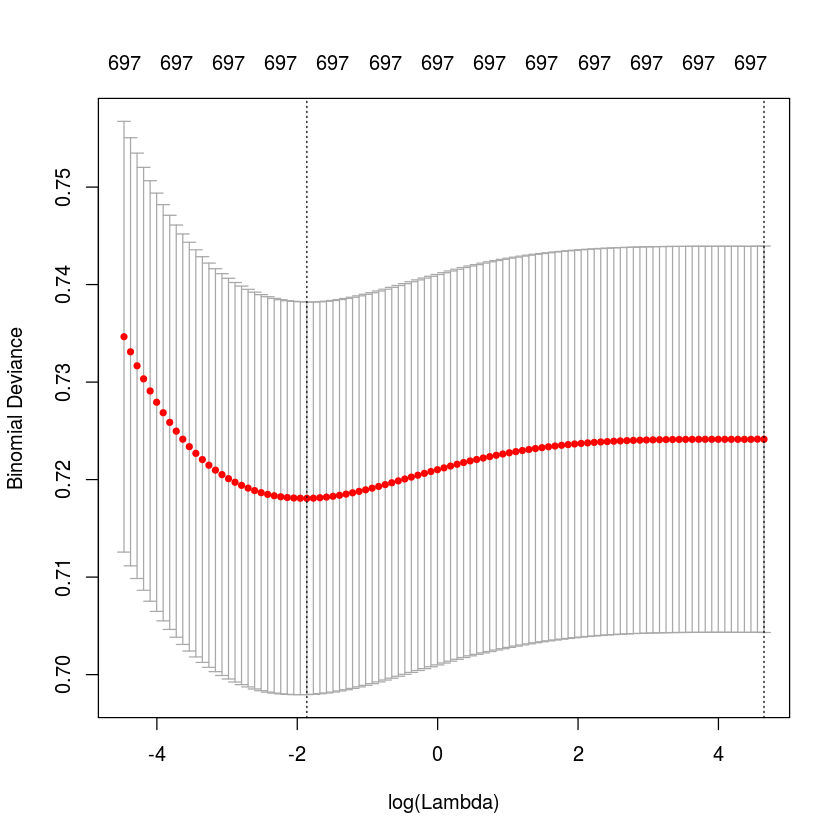

In [20]:
plot(fit_pdwpc$cv_model)

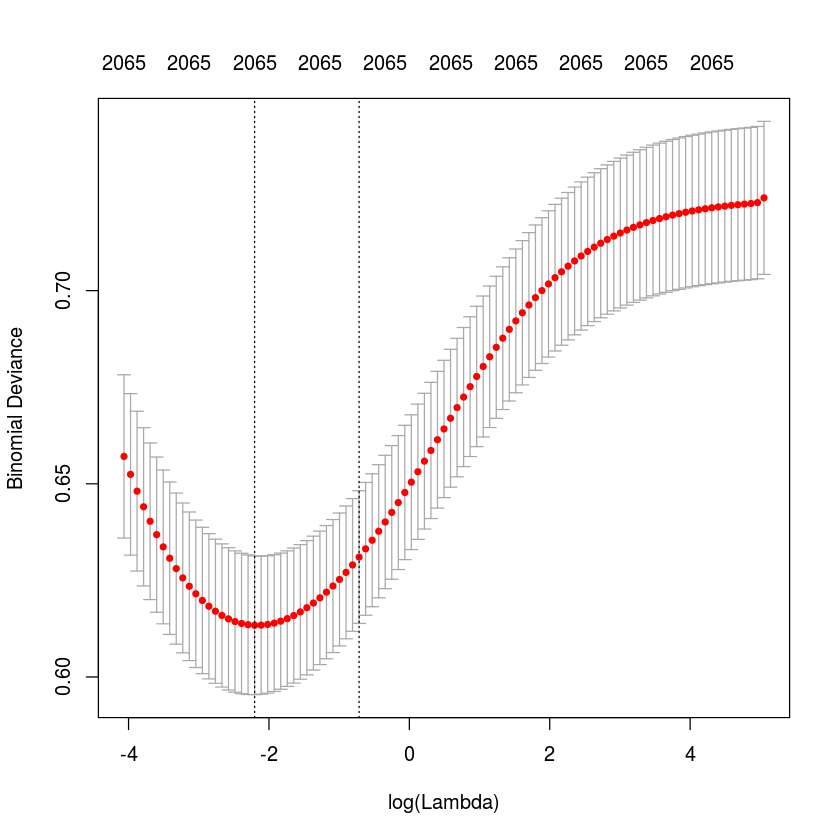

In [21]:
plot(fit_all$cv_model)